# 语料加载

In [34]:
import jieba
import random
import pandas as pd

In [35]:
stopwords = pd.read_csv("data/stopwords.txt", quoting=3, index_col=False, sep="\t", names=["stopword"], encoding="utf-8")
stopwords = stopwords["stopword"].values

In [36]:
laogong_df = pd.read_csv("data/beilaogongda.csv", encoding="utf-8")
laopo_df = pd.read_csv("data/beilaopoda.csv", encoding="utf-8")
erzi_df = pd.read_csv("data/beierzida.csv", encoding="utf-8")
nver_df = pd.read_csv("data/beinverda.csv", encoding="utf-8")

In [37]:
laogong_df.dropna(inplace=True)
laopo_df.dropna(inplace=True)
erzi_df.dropna(inplace=True)
nver_df.dropna(inplace=True)

In [38]:
laogong = laogong_df.segment.values.tolist()
laopo = laopo_df.segment.values.tolist()
erzi = erzi_df.segment.values.tolist()
nver = nver_df.segment.values.tolist()

# 分词和去停用词

In [39]:
def preprocess_text(content_lines, sentences):
    for line in content_lines:
        try:
            segs = jieba.lcut(line)
            # 去空格
            segs = list(filter(lambda x: x.strip(), segs))
            # 去数字
            segs = [v for v in segs if not str(v).isdigit()]
            # 去长度为1的字符
            segs = list(filter(lambda x: len(x) > 1, segs))
            # 去掉停用词
            segs = list(filter(lambda x: x not in stopwords, segs))
            sentences.append((" ").join(segs))
        except Exception as e:
            print(line, str(e))
            continue

In [40]:
sentences = []
preprocess_text(laogong, sentences)
preprocess_text(laopo, sentences)
preprocess_text(erzi, sentences)
preprocess_text(nver, sentences)

In [41]:
random.shuffle(sentences)

In [42]:
sentences[:5]

['报警 女儿 民警 到场',
 '报警 儿子 民警 到场',
 '报警 儿子 持械 人伤 无需 救护 民警 到场 民警 携带 防护 设备',
 '儿子 人无伤 持械 民警 到场',
 '报警 老婆 民警 到场']

# 抽取词向量特征

In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer

In [44]:
# 将文本中的词语转换为词频矩阵 矩阵元素a[i][j] 表示j词在i类文本下的词频
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5)
# 统计每个词的tf-idf权重
transformer = TfidfTransformer()
# 先计算tf-idf, 再讲文本转为词频矩阵
tfidf = transformer.fit_transform(vectorizer.fit_transform(sentences))
# 获取词袋中的所有词语
word = vectorizer.get_feature_names()
weight = tfidf.toarray()

C:\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [45]:
len(word)

476

# 聚类

## 建模

In [46]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [47]:
numClass = 4
# 也可以用init="random"
clf = KMeans(n_clusters=numClass, max_iter=10000, init="k-means++", tol=1e-6)
# 降维
pca = PCA(n_components=10)
# 载入N维
TnewData = pca.fit_transform(weight)
s = clf.fit(TnewData)

## 可视化

In [48]:
import matplotlib.pylab as plt

%matplotlib inline

In [49]:
def plot_cluster(result, newData, numClass):
    plt.figure(2)
    Lab = [[] for i in range(numClass)]
    index = 0
    for labi in result:
        Lab[labi].append(index)
        index += 1
    color = ['oy', 'ob', 'og', 'cs', 'ms', 'bs', 'ks', 'ys', 'yv', 'mv', 'bv', 'kv', 'gv', 'y^', 'm^', 'b^', 'k^',
                 'g^'] * 3 
    for i in range(numClass):
        x1 = []
        y1 = []
        for ind1 in newData[Lab[i]]:
            try:
                y1.append(ind1[1])
                x1.append(ind1[0])
            except:
                pass
        plt.plot(x1, y1, color[i])
    
    # 绘制中心点
    x1 = []
    y1 = []
    for ind1 in clf.cluster_centers_:
        try:
            y1.append(ind1[1])
            x1.append(ind1[0])
        except:
            pass
    plt.plot(x1, y1, "rv")
    plt.show()

## 降到2维

In [51]:
pca = PCA(n_components=2)
newData = pca.fit_transform(weight)
result = list(clf.predict(TnewData))

## 绘图

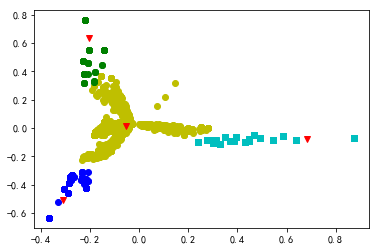

In [52]:
plot_cluster(result, newData, numClass)

## 试试TSNE降维

In [53]:
from sklearn.manifold import TSNE

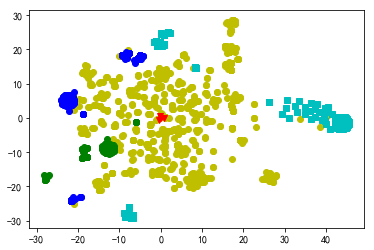

In [54]:
ts = TSNE(2)
newData = ts.fit_transform(weight)
result = list(clf.predict(TnewData))
plot_cluster(result, newData, numClass)

## 先用PCA，再用TSNE

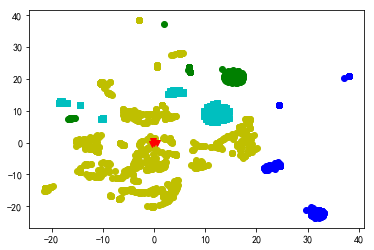

In [55]:
newData = PCA(n_components=4).fit_transform(weight)
newData = TSNE(2).fit_transform(newData)
result = list(clf.predict(TnewData))
plot_cluster(result, newData, numClass)

# 总结